## UKBB+HCP Exploratory Data Analysis

### Imports

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from imports import *

In [9]:
from models import *
from data import * 
from env import *
from harmonize import *
from sim import *

In [10]:
# overall imports
import importlib
import data

# data load
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome
importlib.reload(data.data_load)
importlib.reload(data.data_viz)

# data utils
from data.data_utils import (
    reconstruct_connectome,
    reconstruct_upper_triangle,
    make_symmetric,
    expand_X_symmetric,
    expand_Y_symmetric,
    expand_X_symmetric_shared,
    expand_X_Y_symmetric_conn_only,
    expand_shared_matrices,
    expand_X_symmetric_w_conn, 
    process_cv_splits, 
    process_cv_splits_conn_only_model, 
    expanded_inner_folds_combined_plus_indices
)

import data.data_utils
importlib.reload(data.data_utils)

# cross-validation classes
import data.cv_split
from data.cv_split import RandomCVSplit, SchaeferCVSplit, CommunityCVSplit, SubnetworkCVSplit
importlib.reload(data.cv_split)

# sim class
import sim.sim 
from sim.sim import Simulation
importlib.reload(sim.sim)


<module 'sim.sim' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim.py'>

## Load in structural connectomes

In [11]:
HCP_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/HCP1200_DTI/'
print(HCP_path)

/scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200_DTI/


In [12]:
# Load stuctural connectome from ENIGMA
HCP_enigma_structural_count = load_connectome(measure='SC')
HCP_enigma_structural_count_cortical = HCP_enigma_structural_count[:100, :100]

# Load 156-region structural connectivity matrices
HCP1200_S156_structural_count = np.log1p(loadmat(HCP_path + '/4S156/4S156_DTI_count.mat')['connectivity'])
HCP1200_S156_structural_count_cortical = HCP1200_S156_structural_count[:100, :100]
HCP1200_S156_structural_QA = loadmat(HCP_path + '/4S156/4S156_DTI_QA.mat')['connectivity']
HCP1200_S156_structural_QA_cortical = HCP1200_S156_structural_QA[:100, :100]

# Load 456-region structural connectivity matrices  
HCP1200_S456_structural_count = np.log1p(loadmat(HCP_path + '/4S456/4S456_DTI_count.mat')['connectivity'])
HCP1200_S456_structural_QA = loadmat(HCP_path + '/4S456/4S456_DTI_QA.mat')['connectivity']

## Load in functional connectomes

In [14]:
UKBB_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/Penn_UKBB_data/'
print(UKBB_path)

UKBB_demographics = pd.read_csv(UKBB_path + '/metadata/UKBB_MasterList_DemogInfo_part.csv')
UKBB_demographics.head()

/scratch/asr655/neuroinformatics/GeneEx2Conn_data/Penn_UKBB_data/


,MRID,Age,IsF,Race
0,1000038_2_0,64.64,1.0,British
1,1000108_2_0,68.39,0.0,British
2,1000149_2_0,76.67,0.0,Irish
3,1000201_2_0,67.24,1.0,British
4,1000213_2_0,67.73,1.0,British


In [29]:
UKBB_S156_functional_conn = pd.read_csv('./data/UKBB/UKBB_S156_functional_conn.csv')
UKBB_S156_functional_conn_cortical = np.array(UKBB_S156_functional_conn)[:100, :100]
UKBB_S156_labels = pd.read_csv('./data/UKBB/schaefer156_atlas_info.txt', sep='\t')['label_7network'].tolist()

UKBB_S456_functional_conn = pd.read_csv('./data/UKBB/UKBB_S456_functional_conn.csv')
UKBB_S456_labels = pd.read_csv('./data/UKBB/schaefer456_atlas_info.txt', sep='\t')['label_7network'].tolist()

HCP_functional_conn = load_connectome(measure='FC', omit_subcortical=False)
HCP_functional_conn_cortical = load_connectome(measure='FC', omit_subcortical=True)
HCP_labels = pd.read_csv('./data/enigma/schaef114_regions.txt', header=None).values.flatten().tolist()


### Structure-function correlations

ENIGMA

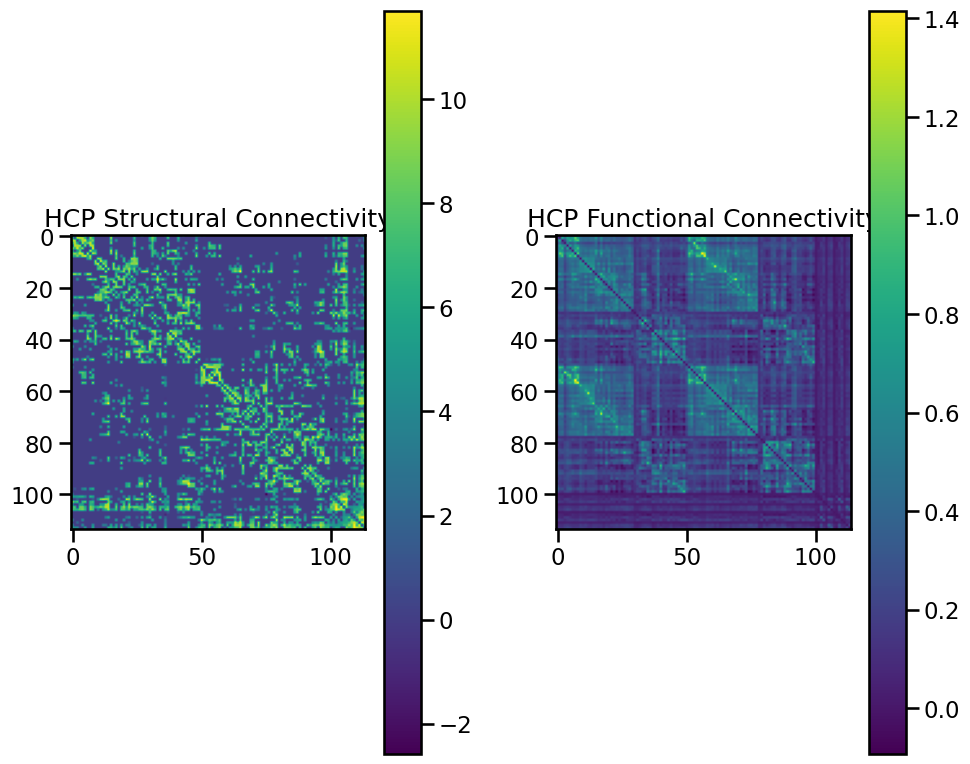

Structure-Function Correlation: 0.173


In [30]:
# Visualize structural connectivity matrix
plt.figure(figsize=(10,8))
plt.subplot(121)
plt.imshow(HCP_enigma_structural_count, cmap='viridis')
plt.colorbar()
plt.title('HCP Structural Connectivity')

# Visualize functional connectivity matrix
plt.subplot(122)
plt.imshow(HCP_functional_conn, cmap='viridis')
plt.colorbar()
plt.title('HCP Functional Connectivity')
plt.tight_layout()
plt.show()

# Compute correlation between structural and functional connectivity
struct_func_corr = np.corrcoef(HCP_enigma_structural_count.flatten(), 
                              HCP_functional_conn.flatten())[0,1]
                              
print(f"Structure-Function Correlation: {struct_func_corr:.3f}")


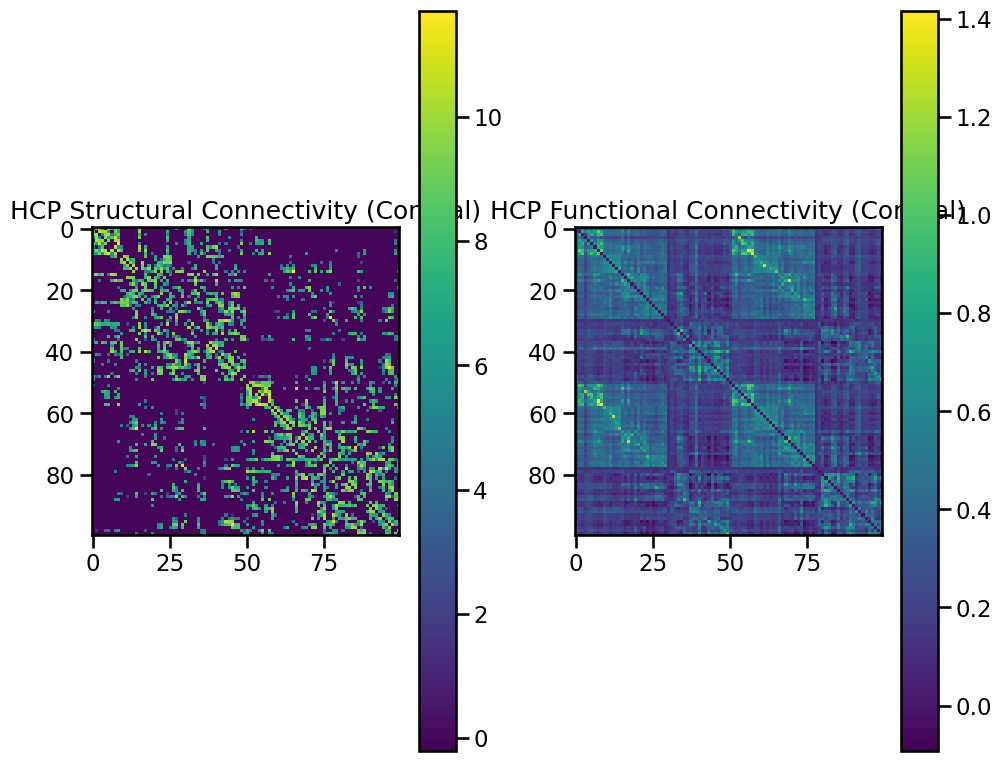

Structure-Function Correlation (Cortical): 0.268


In [31]:
# Visualize structural connectivity matrix
plt.figure(figsize=(10,8))
plt.subplot(121)
plt.imshow(HCP_enigma_structural_count_cortical, cmap='viridis')
plt.colorbar()
plt.title('HCP Structural Connectivity (Cortical)')

# Visualize functional connectivity matrix
plt.subplot(122)
plt.imshow(HCP_functional_conn_cortical, cmap='viridis')
plt.colorbar()
plt.title('HCP Functional Connectivity (Cortical)')
plt.tight_layout()
plt.show()

# Compute correlation between structural and functional connectivity
struct_func_corr = np.corrcoef(HCP_enigma_structural_count_cortical.flatten(), 
                              HCP_functional_conn_cortical.flatten())[0,1]
                              
print(f"Structure-Function Correlation (Cortical): {struct_func_corr:.3f}")


HCP1200-UKBB

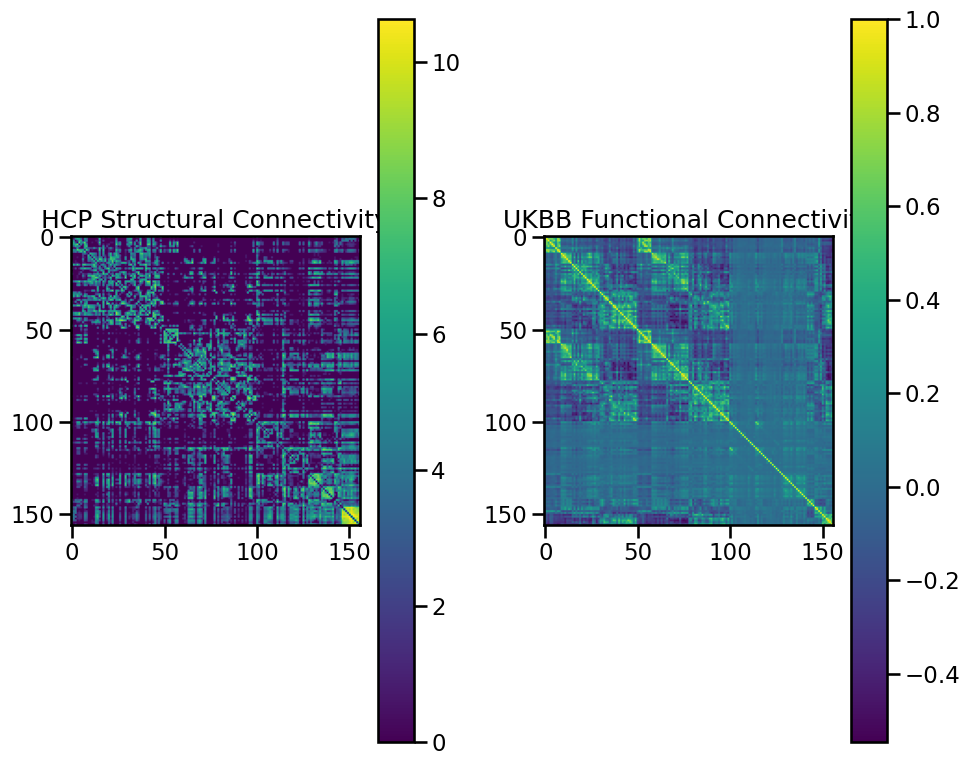

HCP Structure - UKBB Function Correlation: 0.166


In [36]:
# Visualize structural connectivity matrix from HCP and functional from UKBB
plt.figure(figsize=(10,8))
plt.subplot(121)
plt.imshow(HCP1200_S156_structural_count, cmap='viridis')
plt.colorbar()
plt.title('HCP Structural Connectivity')

plt.subplot(122)
plt.imshow(UKBB_S156_functional_conn, cmap='viridis')
plt.colorbar() 
plt.title('UKBB Functional Connectivity')
plt.tight_layout()
plt.show()

# Compute correlation between HCP structural and UKBB functional connectivity
struct_func_corr = np.corrcoef(np.array(HCP1200_S156_structural_count).flatten(),
                              np.array(UKBB_S156_functional_conn).flatten())[0,1]

print(f"HCP Structure - UKBB Function Correlation: {struct_func_corr:.3f}")


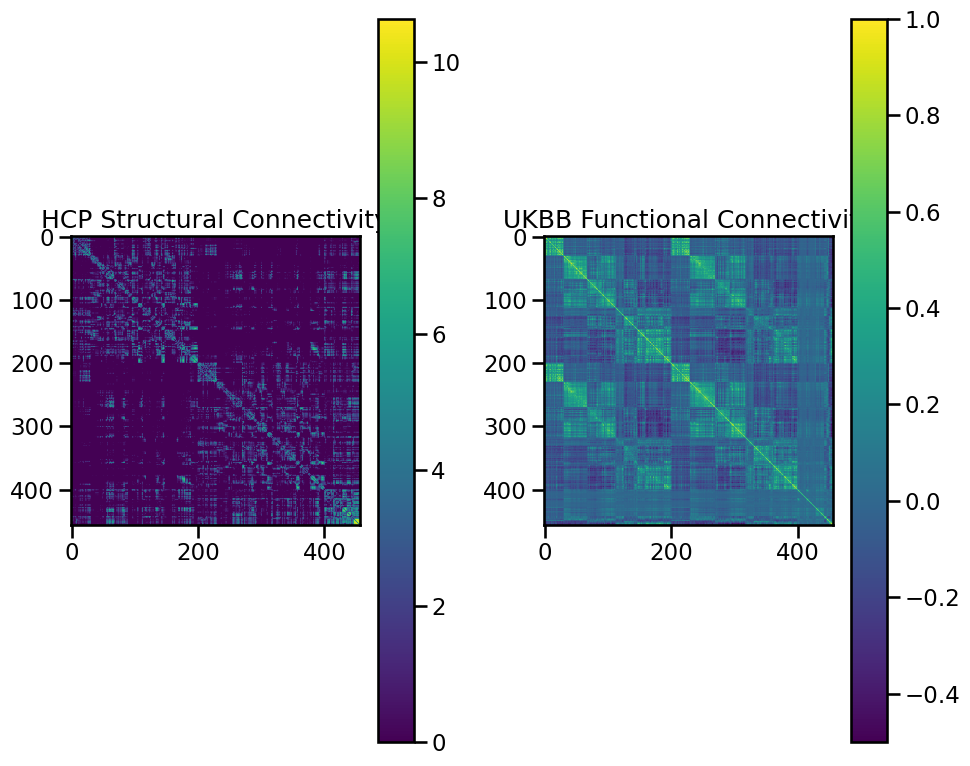

HCP Structure - UKBB Function Correlation: 0.180


In [37]:
# Visualize structural connectivity matrix from HCP and functional from UKBB
plt.figure(figsize=(10,8))
plt.subplot(121)
plt.imshow(HCP1200_S456_structural_count, cmap='viridis')
plt.colorbar()
plt.title('HCP Structural Connectivity')

plt.subplot(122)
plt.imshow(UKBB_S456_functional_conn, cmap='viridis')
plt.colorbar() 
plt.title('UKBB Functional Connectivity')
plt.tight_layout()
plt.show()

# Compute correlation between HCP structural and UKBB functional connectivity
struct_func_corr = np.corrcoef(np.array(HCP1200_S456_structural_count).flatten(),
                              np.array(UKBB_S456_functional_conn).flatten())[0,1]

print(f"HCP Structure - UKBB Function Correlation: {struct_func_corr:.3f}")


### Low-dimensional visualization combining transcriptome and connectome

In [41]:
AHBA_transcriptome = load_transcriptome(omit_subcortical=False)

print('transcriptome', AHBA_transcriptome.shape)
print('structural connectome', HCP_enigma_structural_count.shape)
print('functional connectome', HCP_functional_conn.shape)

transcriptome (114, 11053)
structural connectome (114, 114)
functional connectome (114, 114)
